### Building an ANN

### Input is MNIST Fashion dataset, to classify fashion articles. 28x28 pictures.

### 4 layers, 1 input layer (784), 2 hidden layers(128 and 64) and 1 output layer (10)

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(42)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import zipfile
import os

file_path = "/content/archive.zip"
output_dir = "/content/"

os.makedirs(output_dir, exist_ok=True)

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print(f"File extracted to {output_dir}")

File extracted to /content/


In [5]:
df = pd.read_csv("/content/fashion-mnist_train.csv")

In [6]:
df.shape

(60000, 785)

In [ ]:
# df = df.sample(n=6000, random_state=42)

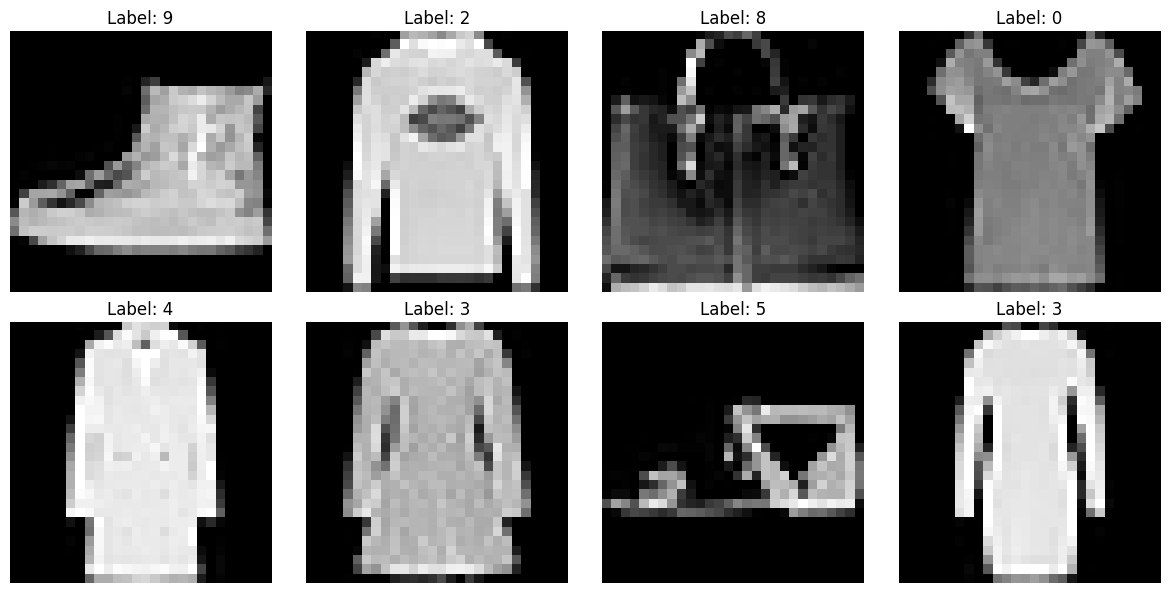

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Select 8 random indices
random_indices = np.random.choice(df.index, size=8, replace=False)

# Get the images and labels for the selected indices
random_images = df.loc[random_indices, df.columns != 'label'].values
random_labels = df.loc[random_indices, 'label'].values

# Reshape the images to 28x28
random_images = random_images.reshape(-1, 28, 28)

# Display the images
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(random_images[i], cmap='gray')
    plt.title(f"Label: {random_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
display(df['label'].value_counts().sort_index())

,count
label,
0,6000
1,6000
2,6000
3,6000
4,6000
5,6000
6,6000
7,6000
8,6000


In [9]:
# test train split

x = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [10]:
# scaling

x_train = x_train/255.0
x_test = x_test/255.0

In [26]:
# create customdataset class

class CustomDataset(Dataset):

  def __init__(self, features, labels):
    self.features = torch.tensor(features,dtype=torch.float32).reshape(-1,1,28,28)
    self.labels = torch.tensor(labels,dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    return self.features[index], self.labels[index]

In [27]:
# create train_dataset object

train_dataset = CustomDataset(x_train, y_train)

In [13]:
len(train_dataset)
train_dataset[1]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [28]:
# create test_dataset object

test_dataset = CustomDataset(x_test, y_test)

In [30]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [37]:
class MyNN(nn.Module):
  def __init__(self, input_features):
    super().__init__()

    # feature extraction
    self.features = nn.Sequential(
        nn.Conv2d(input_features, 32, kernel_size=3, stride=1, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # classifier
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(64*7*7, 128),
        nn.ReLU(),
        nn.Dropout(0.4),

        nn.Linear(128,64),
        nn.ReLU(),
        nn.Dropout(0.4),

        nn.Linear(64,10)
    )

  def forward(self, x):
    x = self.features(x)
    x = self.classifier(x)

    return x

In [38]:
epochs = 100
learning_rate = 0.01

In [39]:
# instantiate model
model = MyNN(1)
model.to(device)

# instatntiate loss function
criterion = nn.CrossEntropyLoss()

# opimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 1e-4)

In [35]:
# print number of batches
len(train_loader)

1500

In [40]:
for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    # forward pass
    outputs = model(batch_features)

    # calcultae loss
    loss = criterion(outputs, batch_labels)

    # backward pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

  print(f"Epoch: {epoch+1}, Loss: {total_epoch_loss/len(train_loader)}")

Epoch: 1, Loss: 0.6607684432466825
Epoch: 2, Loss: 0.38460053913295267
Epoch: 3, Loss: 0.3272090838601192
Epoch: 4, Loss: 0.28770059603701037
Epoch: 5, Loss: 0.26497445272281767
Epoch: 6, Loss: 0.24665976429109773
Epoch: 7, Loss: 0.2293034341596067
Epoch: 8, Loss: 0.21504798182006926
Epoch: 9, Loss: 0.2014385415116946
Epoch: 10, Loss: 0.1867190728103742
Epoch: 11, Loss: 0.18000925815664232
Epoch: 12, Loss: 0.1686230296542247
Epoch: 13, Loss: 0.1596255717811485
Epoch: 14, Loss: 0.15135696713191768
Epoch: 15, Loss: 0.14012252739071845
Epoch: 16, Loss: 0.1371868281949622
Epoch: 17, Loss: 0.1281045542396605
Epoch: 18, Loss: 0.12531434754344326
Epoch: 19, Loss: 0.11259790725074709
Epoch: 20, Loss: 0.11234660568786785
Epoch: 21, Loss: 0.10504294176845967
Epoch: 22, Loss: 0.09848812762803087
Epoch: 23, Loss: 0.09660158565624928
Epoch: 24, Loss: 0.09066466652586436
Epoch: 25, Loss: 0.08509256301928933
Epoch: 26, Loss: 0.08615734134342831
Epoch: 27, Loss: 0.07780400107878571
Epoch: 28, Loss: 0.

In [41]:
model.eval()

MyNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [ ]:
len(test_loader)

188

In [43]:
# evaluation code

total = 0
correct = 0

with torch.no_grad():
  for batch_features, batch_labels in test_loader:

    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    outputs = model(batch_features)
    _, predicted = torch.max(outputs, 1)
    total = total + batch_labels.shape[0]
    correct = correct + (predicted == batch_labels).sum().item()

print(f"Accuracy on test: {correct/total}")

# evaluation on training data

total = 0
correct = 0

with torch.no_grad():
  for batch_features, batch_labels in train_loader:

    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    outputs = model(batch_features)
    _, predicted = torch.max(outputs, 1)
    total = total + batch_labels.shape[0]
    correct = correct + (predicted == batch_labels).sum().item()

print(f"Accuracy on train: {correct/total}")

Accuracy on test: 0.9233333333333333
Accuracy on train: 0.9995833333333334
